In [0]:
#import modules and libraries
from keras.optimizers import Adam
import numpy as np


In [0]:
#seed random seed for reproducibility
seed=10
np.random.seed(seed)

In [0]:
#specifies the length of the random noise vector, z
noise_dim = 100
batch_size = 16
#we perform 3750 steps per epoch as 60000, the number of examples in MNIST data
steps_per_epoch = 3750
epochs = 10

In [0]:
#name of the directory you want to create
save_path = 'GAN_IMAGES'
#DEFINE IMAGE PARAMETERS
img_rows, img_cols, channels = 28, 28, 1

In [0]:
#define optimizer pass in the learning rate and the beta parameter
optimizer = Adam(0.0002, 0.5)

In [0]:
#import the data mnist dataset from keras
from keras.datasets import mnist

In [0]:
#load data of train and test
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [0]:
#normalize the train datasets
Xtrain = (Xtrain.astype(np.float32) - 127.5) / 127.5

In [0]:
#reshape the train datasets
Xtrain = Xtrain.reshape(-1, img_rows * img_cols * channels)
Xtrain.shape

(60000, 784)

In [0]:

#import os #specifying/making a directory to save the images generated during training, if it does not already exists.
import os
#conditional statement to check whether the directory exists
if not os.path.isdir(save_path):
  #make a directory and save the image in the file path
  os.mkdir(save_path)

In [0]:
##create our generator for the GAN
#The generator is going take samples of noise(z) from an unknown probability distribution and generate images
#IMPORT MODULES
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

In [0]:
#create the generator
def create_generator():

  generator = Sequential()

  generator.add(Dense(256, input_dim=noise_dim))#noise_dim is the sample we are generating
  generator.add(LeakyReLU(0.2))#0.3 is the default it is the value we will use to adjust our x

  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))

  #We must use the tanh activation for the final layer to stay consistent with our normalization of the images earlier, and for better results.
  generator.add(Dense(img_rows * img_cols * channels, activation='tanh'))

  #compile the model
  #we use the binary cross entropy loss we are interested in the probability of the outputs of the Generator
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)

  #return model
  return generator

In [0]:
#creating a discriminator
def create_discriminator():
  discriminator = Sequential()
  discriminator.add(Dense(1024, input_dim= img_rows * img_cols * channels))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(1, activation='sigmoid'))

  #compile model
  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

  #return model
  return discriminator

In [0]:
#set up GAN for trainning
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator()
generator = create_generator()

#set this to false so that it trains the models at the same time
discriminator.trainable = False

#generate the sample and pass through the generator
gan_input = Input(shape=(noise_dim, ))
fake_image = generator(gan_input)

#get the output
gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)

#compile the two models
gan.compile(loss='binary_crossentropy', optimizer=optimizer)



In [0]:
#since we have two models, we cannot use the keras.fit function rather we will use a for loop to generate the noise vector, (z)and pass it through the generator
for epoch in range(epochs):
  for batch in range(steps_per_epoch):

    #generate some random sample noise from a standard normal distribution
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

    #generate the fake images
    fake_x = generator.predict(noise)

    #generate some samples from the true distribution
    real_x = Xtrain[np.random.randint(0, Xtrain.shape[0], size=batch_size)]

    #concatenate the real and the fake images #use two brackets since want a tuple
    x = np.concatenate((real_x, fake_x))

    #create a list of zeros that will be two times our batch size   0.9 to real and 0.1 to fake images
    disc_y = np.zeros(2*batch_size)
    disc_y[:batch_size] = 0.9

    #calculate the discriminator loss
    discriminator_loss = discriminator.train_on_batch(x, disc_y)

    # create outputs for the generator
    y_generator = np.ones(batch_size)
    
    #calculate generator loss
    generator_loss = gan.train_on_batch(noise, y_generator)

  print(f'Epoch: {epoch} \t Discriminator Loss: {discriminator_loss} \t\t Generator Loss: {generator_loss}')    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.4925800561904907 		 Generator Loss: 1.7927995920181274
Epoch: 1 	 Discriminator Loss: 0.5169828534126282 		 Generator Loss: 1.736263632774353
Epoch: 2 	 Discriminator Loss: 0.6138548851013184 		 Generator Loss: 1.4029006958007812
Epoch: 3 	 Discriminator Loss: 0.5247771739959717 		 Generator Loss: 1.5746936798095703
Epoch: 4 	 Discriminator Loss: 0.5433695316314697 		 Generator Loss: 1.4798176288604736
Epoch: 5 	 Discriminator Loss: 0.7567474842071533 		 Generator Loss: 1.3697879314422607
Epoch: 6 	 Discriminator Loss: 0.5339227914810181 		 Generator Loss: 1.8491578102111816
Epoch: 7 	 Discriminator Loss: 0.5825532674789429 		 Generator Loss: 1.593991994857788
Epoch: 8 	 Discriminator Loss: 0.5361602306365967 		 Generator Loss: 1.7923879623413086
Epoch: 9 	 Discriminator Loss: 0.6835029125213623 		 Generator Loss: 1.3616437911987305


In [0]:
import matplotlib.pyplot as plt

def show_images(noise):

  #generate the fake images using the noise vector and plot them
  generated_images = generator.predict(noise)
  plt.figure(figsize=(10,10))

  #loop through the index and images in the fake images
  for i, image in enumerate(generated_images):
    plt.subplot(10, 10, i+1)

    #condition for a grayscale image using the number of channels
    if channels == 1:
      plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')

    #condition for the coloured image
    else:
      plt.imshow(image.reshape((img_rows, img_cols, channels)))

    #switch off axis
    plt.axis('off')

  plt.tight_layout()
  plt.show()      

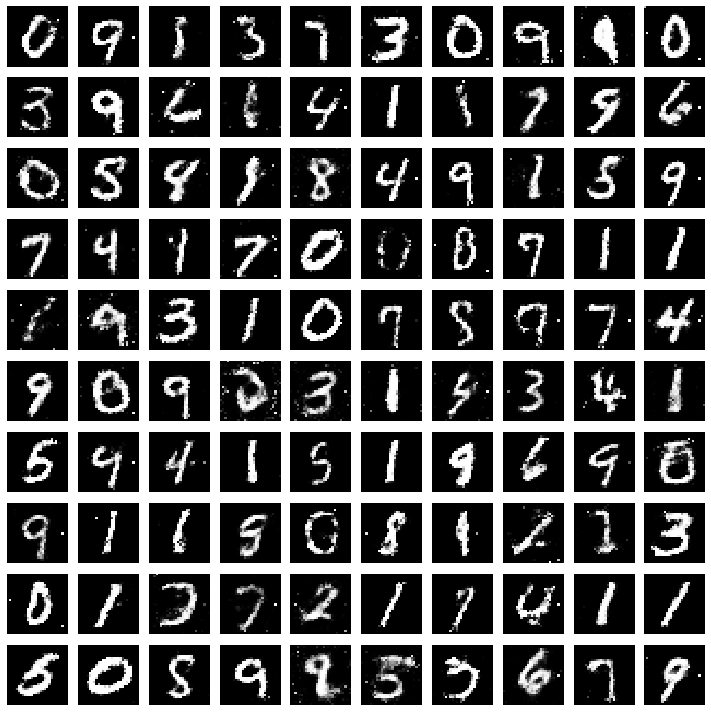

In [0]:
#show images from noise
#sample the noise vector from a standard normal distribution 
noise = np.random.normal(0, 1, size = (100, noise_dim))
show_images(noise)